In [1]:
import pandas as pd
import numpy as np
import nltk


In [2]:
from gensim.models import Word2Vec

In [3]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# Ensure nltk dependencies are available
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load dataset
train = pd.read_csv('../date/train_data_cleaned.csv')
test = pd.read_csv('../date/test_data_cleaned.csv')
val = pd.read_csv('../date/val_data_cleaned.csv')


In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
from nltk.stem import LancasterStemmer

# Initialize the Lancaster stemmer
stemmer = LancasterStemmer()

# Preprocessing function with Lancaster stemming
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)


In [33]:
# Aplică preprocesarea pe coloanele de interes
train['processed_text'] = train['text'].apply(preprocess_text)
train['processed_title'] = train['title'].apply(preprocess_text)

val['processed_text'] = val['text'].apply(preprocess_text)
val['processed_title'] = val['title'].apply(preprocess_text)

test['processed_text'] = test['text'].apply(preprocess_text)
test['processed_title'] = test['title'].apply(preprocess_text)


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combină textul și titlul
train['combined_text'] = train['processed_title'] + " " + train['processed_text']
val['combined_text'] = val['processed_title'] + " " + val['processed_text']
test['combined_text'] = test['processed_title'] + " " + test['processed_text']

In [10]:
# Pregătirea datelor pentru model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['combined_text'])

# Transformă textele în secvențe
X_train = tokenizer.texts_to_sequences(train['combined_text'])
X_val = tokenizer.texts_to_sequences(val['combined_text'])
X_test = tokenizer.texts_to_sequences(test['combined_text'])

In [11]:
# Aplică padding
max_length = 100
X_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test, maxlen=max_length, padding='post')

# Pregătire etichete
y_train = train['label']
y_val = val['label']
y_test = test['label']

In [12]:
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Antrenează un model Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in train['combined_text']], vector_size=100, window=5, min_count=1, workers=4)

In [13]:
# Creează matricea de embedding
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
# Construiește modelul RNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Creează callback-uri
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitorizează accuracy pe setul de validare
    patience=3,              # Așteaptă 3 epoci fără îmbunătățire
    restore_best_weights=True  # Reîncarcă greutățile celui mai bun model
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Salvează cel mai bun model într-un fișier
    monitor='val_accuracy',  # Monitorizează accuracy pe setul de validare
    save_best_only=True,     # Salvează doar dacă modelul este mai bun
    verbose=1
)

In [20]:
# Antrenează modelul
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]  # Adaugă callback-urile
)

# Încarcă cel mai bun model salvat
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

# Predicții folosind cel mai bun model
y_pred = (best_model.predict(X_test_pad) > 0.5).astype('int32')

# Evaluare
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6970 - loss: 0.5735
Epoch 1: val_accuracy improved from -inf to 0.81531, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.6978 - loss: 0.5726 - val_accuracy: 0.8153 - val_loss: 0.4122
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8234 - loss: 0.4112
Epoch 2: val_accuracy improved from 0.81531 to 0.82030, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.8234 - loss: 0.4111 - val_accuracy: 0.8203 - val_loss: 0.3896
Epoch 3/20
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8512 - loss: 0.3508
Epoch 3: val_accuracy improved from 0.82030 to 0.83195, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - accuracy: 0.8511 - loss: 0.3509 - val_accuracy: 0.8319 - val_loss: 0.3773
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8537 - loss: 0.3421
Epoch 4: val_accuracy did not improve from 0.83195
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.8537 - loss: 0.3420 - val_accuracy: 0.8236 - val_loss: 0.3866
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8699 - loss: 0.3115
Epoch 5: val_accuracy improved from 0.83195 to 0.84193, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.8699 - loss: 0.3116 - val_accuracy: 0.8419 - val_loss: 0.3614
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8574 - loss: 0.3219
Epoch 6: val_accuracy improved from 0.84193 to 0.85691, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.8576 - loss: 0.3216 - val_accuracy: 0.8569 - val_loss: 0.3508
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8880 - loss: 0.2779
Epoch 7: val_accuracy improved from 0.85691 to 0.85857, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.8880 - loss: 0.2779 - val_accuracy: 0.8586 - val_loss: 0.3344
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9017 - loss: 0.2527
Epoch 8: val_accuracy improved from 0.85857 to 0.88020, saving model to best_model.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9016 - loss: 0.2527 - val_accuracy: 0.8802 - val_loss: 0.3258
Epoch 9/20
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8783 - loss: 0.2913
Epoch 9: val_accuracy did not improve from 0.88020
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.8785 - loss: 0.2909 - val_accuracy: 0.8536 - val_loss: 0.3553
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9137 - loss: 0.2275
Epoch 10: val_accuracy did not improve from 0.88020
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9136 - loss: 0.2277 - val_accuracy: 0.8552 - val_loss: 0.3346
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9030 - loss: 0.2278
Epoch 11: val_accuracy did not improve from 0.88020
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 0.9030 - loss: 0.2277 - val_accuracy: 0.8552 - val_loss: 0.3808


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Accuracy: 0.8718801996672213
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       320
           1       0.86      0.87      0.86       281

    accuracy                           0.87       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.87      0.87      0.87       601



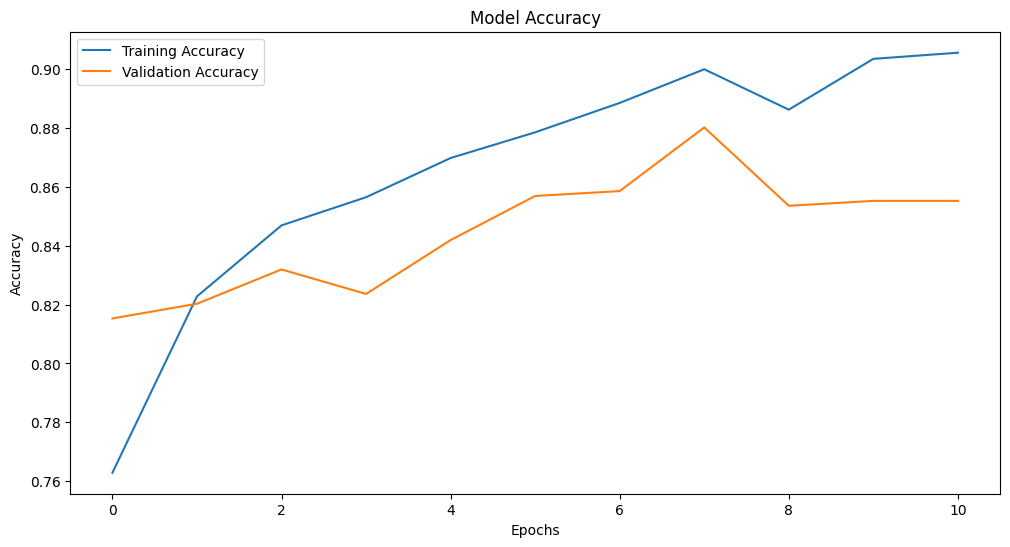

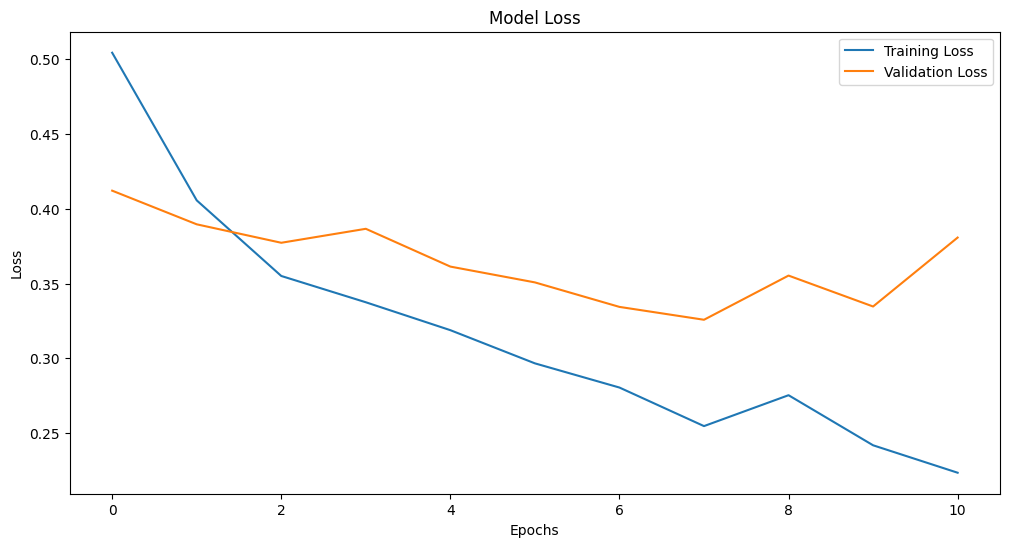

In [21]:
import matplotlib.pyplot as plt

# Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
%pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


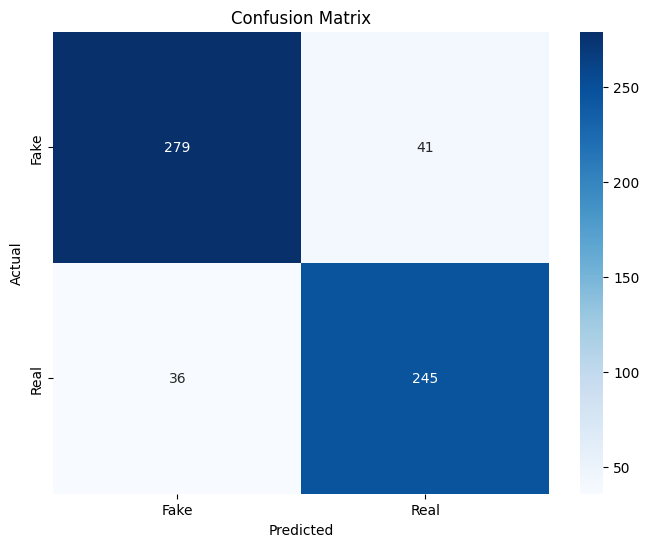

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


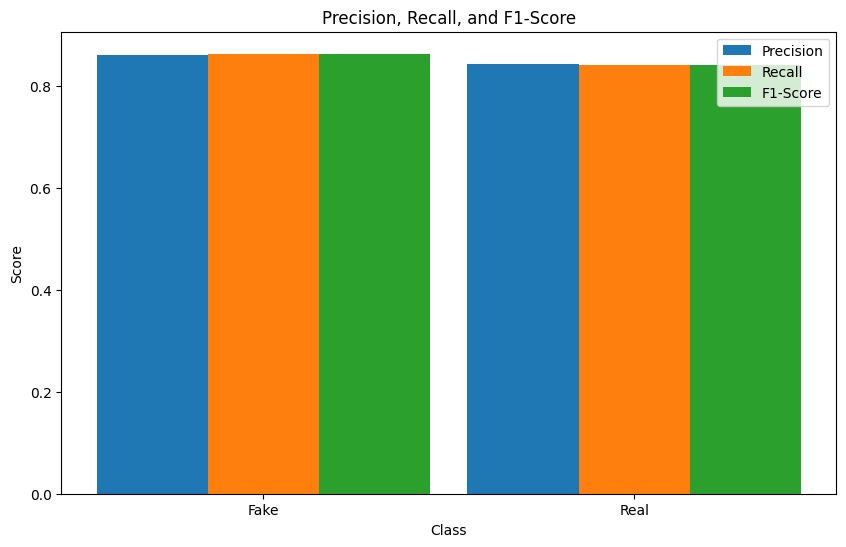

In [24]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Bar plot for metrics
labels = ['Fake', 'Real']
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
width = 0.3
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.title('Precision, Recall, and F1-Score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(x, labels)
plt.legend()
plt.show()


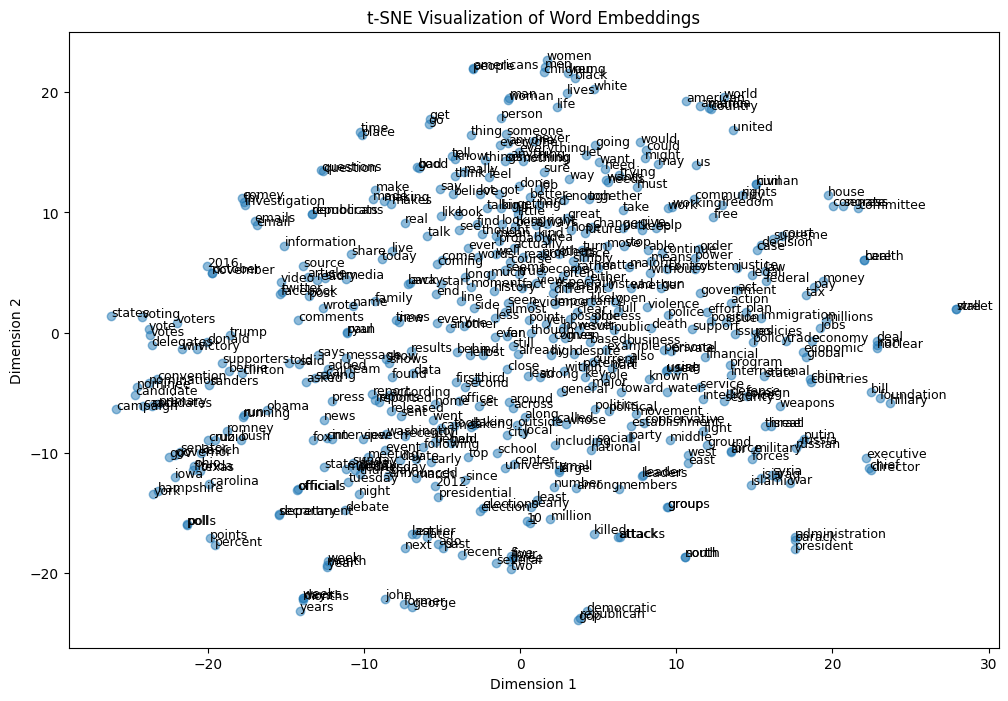

In [23]:
from sklearn.manifold import TSNE

# Extract word vectors and corresponding words
words = list(w2v_model.wv.index_to_key)
word_vectors = w2v_model.wv[words]

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors[:500])  # Visualize top 500 words

# Plot t-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.5)
for i, word in enumerate(words[:500]):
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=9)
plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


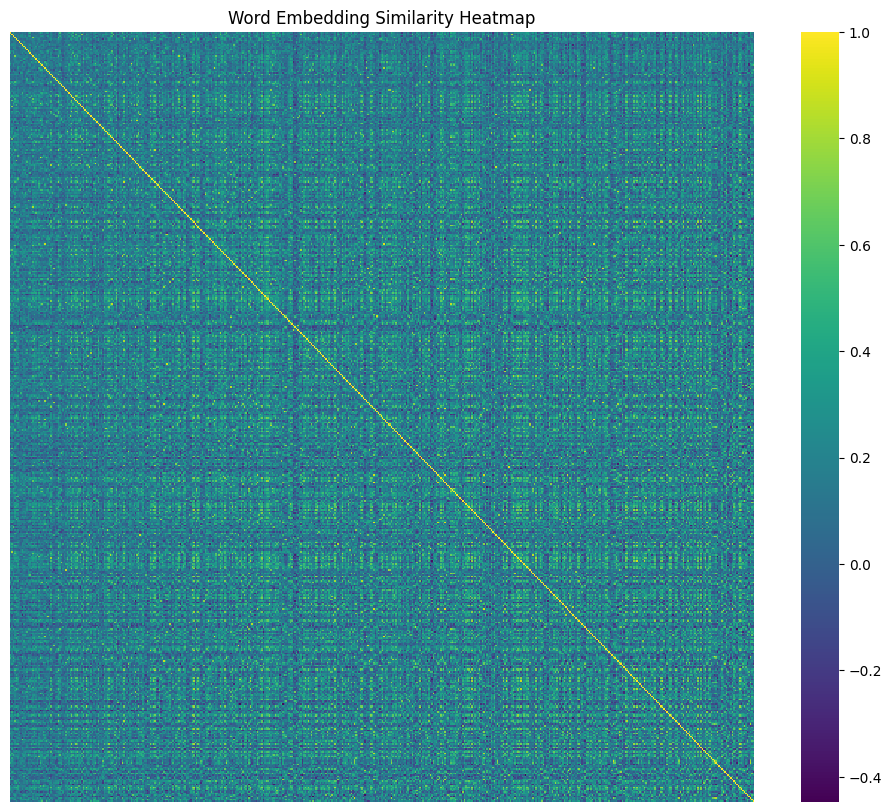

In [24]:
import seaborn as sns

# Compute cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_vectors[:500])  # Use top 500 words
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Word Embedding Similarity Heatmap')
plt.show()


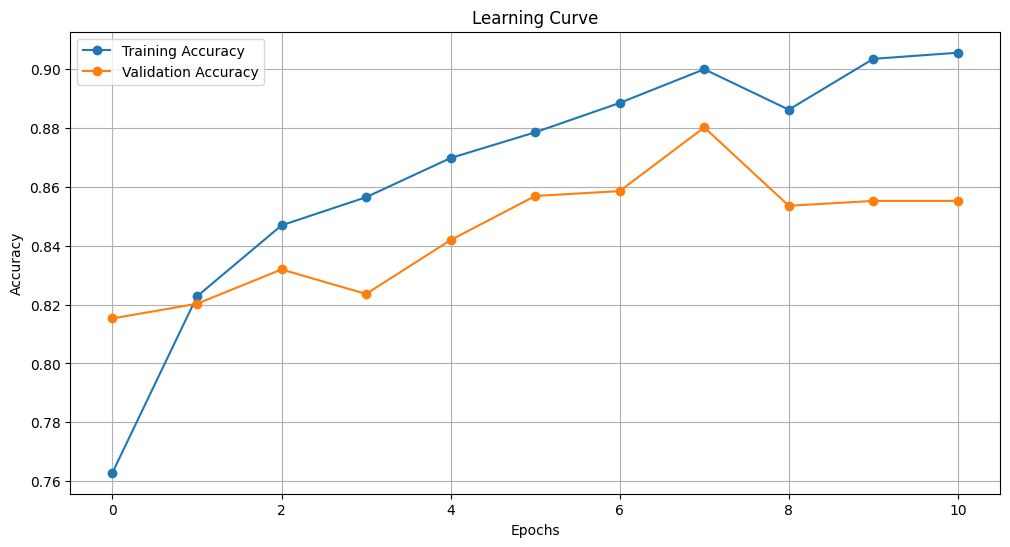

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


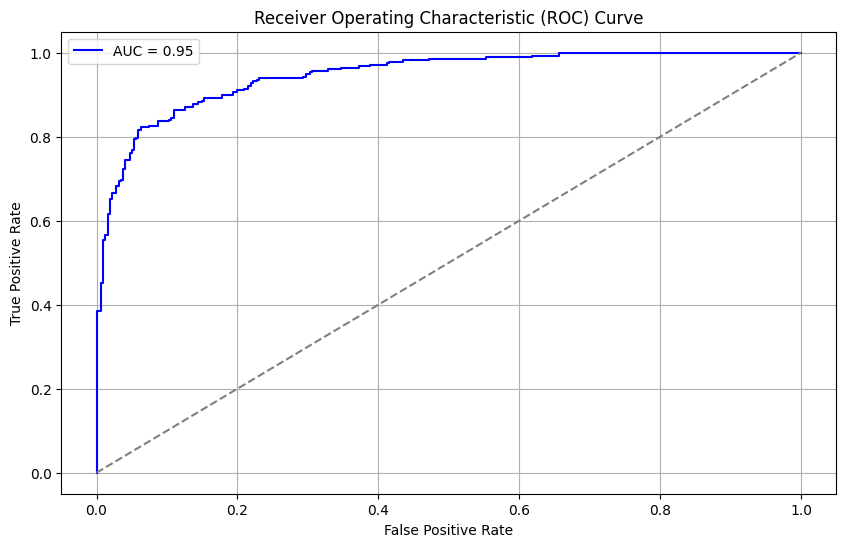

In [28]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
y_pred_prob = best_model.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


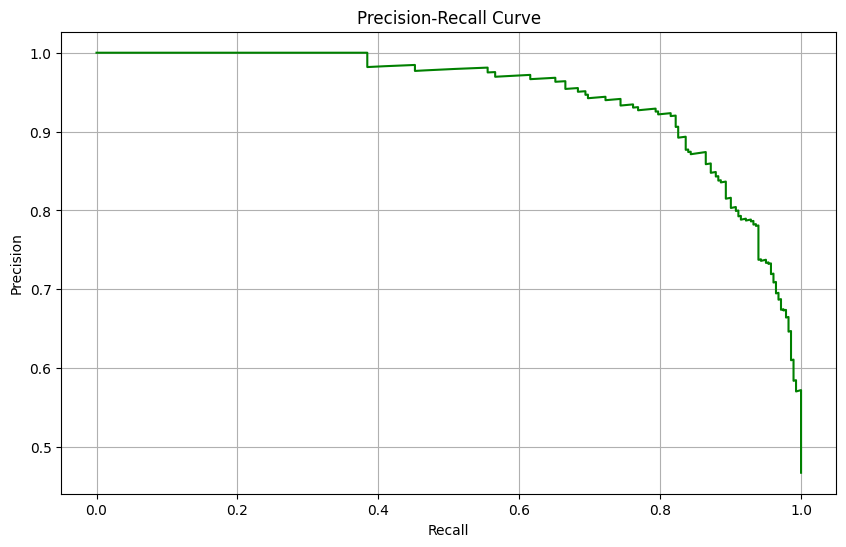

In [29]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()
